In [1]:
import os
from pathlib import Path
from operator import itemgetter
import pickle
import pydicom
from time import time
import pandas

import matplotlib.pyplot as plt
import numpy as np

from catch_converter.parse_contours import parse_cvi42ws
from LazyLuna.Mini_LL import *
from LazyLuna.CATCH_utils import *
from LazyLuna.Tables  import *
from LazyLuna.Figures import *

In [2]:
# basepaths
bp        = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases'
bp_annos1 = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/JGold'
bp_annos2 = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/FCN'
bp_cases  = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Cases'
bp_imgs   = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Imgs'

In [ ]:
# get the paths of imgs and annotations via SeriesInstanceUIDs
imgsanno_paths = get_imgs_and_annotation_paths(bp_imgs, bp_annos)

print('Nr of path tuples: ', len(imgsanno_paths))
case_names = sorted([c[0] for c in imgsanno_paths])
from pprint import pprint
print('Existing Annotations: ', len(sorted([c[0] for c in imgsanno_paths if os.path.exists(c[1])])))
pprint(sorted([c[0] for c in imgsanno_paths if os.path.exists(c[1])]))

cases = []
sax_cine_view = SAX_CINE_View()
sax_cs_view   = SAX_CS_View()
for count, (imgp,annop) in enumerate(imgsanno_paths):
    print(count)
    print(os.path.basename(imgp), os.path.basename(annop))
    st = time()
    case = Case(imgp, annop, os.path.basename(imgp), os.path.basename(bp_annos))
    case = sax_cine_view.initialize_case(case)
    case = sax_cs_view  .initialize_case(case)
    case.store(bp_cases)
    cases.append(case)
    print('Case customization took: ', time()-st, 'Case: ', case.reader_name, case.case_name)
    print()

In [3]:
cases  = [pickle.load(open(os.path.join(bp_cases, p), 'rb')) for p in os.listdir(bp_cases)]
cases1 = sorted([c for c in cases if c.reader_name=='Gold'], key=lambda c: c.case_name)
cases2 = sorted([c for c in cases if c.reader_name=='FCN'],  key=lambda c: c.case_name)

sax_cine_view = SAX_CINE_View()
sax_cs_view   = SAX_CS_View()
ccs = [Case_Comparison(sax_cs_view.customize_case(c1), sax_cs_view.customize_case(c2)) for c1,c2 in zip(cases1,cases2)]

In [ ]:
table = CC_ClinicalResultsTable()
table.calculate(ccs, True)
table.add_bland_altman_dataframe(ccs)
display(table.df)

plot = SAX_BlandAltman()
plot.visualize(ccs)
plot.store('/Users/dietrichhadler/Desktop')
plot = SAX_Candlelight()
plot.visualize(ccs)
plot.store('/Users/dietrichhadler/Desktop')

In [ ]:
view = SAX_CINE_View()
case = view.customize_case(case)
print(case.case_name)

print(case.type)
print(case.categories)
print(case.other_categories)
print(case.all_imgs_sop2filepath.keys())
for k in case.all_imgs_sop2filepath.keys():
    print(k, len(case.all_imgs_sop2filepath[k]), end=', ')
for cr in case.crs:
    print(cr.name, cr.get_cr(), end=', ')

In [ ]:
vis = SAX_BlandAltman()
vis.calculate(ccs)
vis.fig

In [ ]:
vis = SAX_Candlelight()
vis.calculate(ccs)
vis.fig

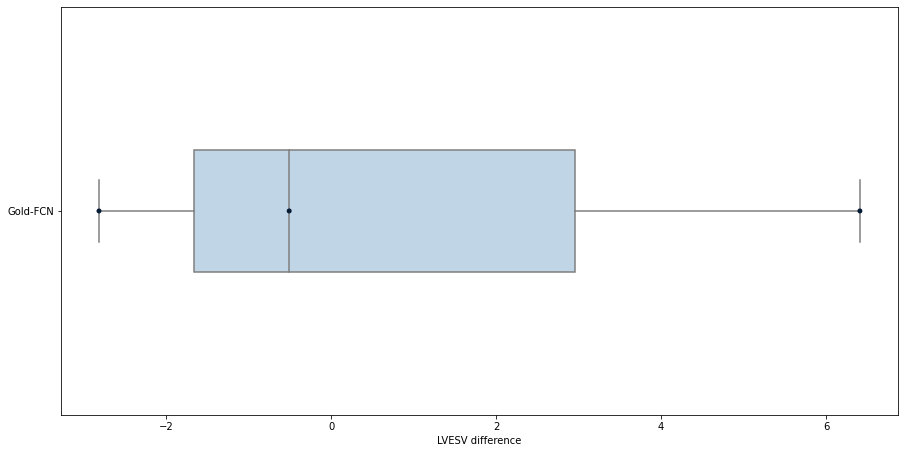

In [26]:
class Boxplot(Visualization):
    def set_values(self, view, canvas):
        self.view   = view
        self.canvas = canvas
        
    def visualize(self, case_comparisons, cr_name):
        self.cr_name = cr_name
        cr = [cr for cr in case_comparisons[0].case1.crs if cr.name==cr_name][0]
        ax = self.add_subplot(111)
        self.set_size_inches(w=15, h=7.5)
        custom_palette  = sns.color_palette([sns.color_palette("Blues")[1], sns.color_palette("Purples")[1]])
        swarm_palette   = sns.color_palette(["#061C36", "#061C36"])
        
        rows = []
        for cc in case_comparisons:
            cr1 = [cr for cr in cc.case1.crs if cr.name==cr_name][0]
            cr2 = [cr for cr in cc.case2.crs if cr.name==cr_name][0]
            rows.append([cc.case1.reader_name+'-'+cc.case2.reader_name, cr1.get_cr_diff(cr2)])
        df = DataFrame(rows, columns=['Reader', cr_name+' difference'])

        # Plot
        sns.boxplot  (ax=ax, data=df, y='Reader', x=cr_name+' difference', orient='h', width=0.3, palette=custom_palette)
        sns.swarmplot(ax=ax, data=df, y='Reader', x=cr_name+' difference', orient='h', palette=swarm_palette)
        ax.set_ylabel('')
        #ax.get_yticklabels()
        #ax.set_yticklabels([case_comparisons[0].case1.reader_name+'-'+case_comparisons[0].case2.reader_name], rotation=90)
        texts = [str(i) for i in range(len(df))]
        
        annot = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords="offset points", 
                            bbox=dict(boxstyle="round", fc="w"), arrowprops=dict(arrowstyle="->"))
        annot.set_visible(False)
        
        
        def update_annot(ind):
            pos = ax.collections[0].get_offsets()[ind["ind"][0]]
            print(pos)
            annot.xy = pos
            annot.set_text(texts[ind['ind'][0]])
            #annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
            #annot.get_bbox_patch().set_alpha(0.3)
        
        def hover(event):
            vis = annot.get_visible()
            if event.inaxes==ax:
                cont, ind = ax.collections[0].contains(event)
                if cont:
                    update_annot(ind)
                    annot.set_visible(True)
                    self.canvas.draw_idle()
                else:
                    if vis:
                        annot.set_visible(False)
                        self.canvas.draw_idle()
        
        self.canvas.mpl_connect("motion_notify_event", hover)
        
    
    def store(self, storepath, figurename='_bland_altman.png'):
        self.savefig(os.path.join(storepath, self.cr_name+figurename), dpi=100, facecolor="#FFFFFF")


ba = Boxplot()
ba.visualize(ccs, 'LVESV')
ba